In [1]:
import torch
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [2]:
def load_cifar_batches(batch_files):
    data, labels = [], []
    for batch_file in batch_files:
        with open(batch_file, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            data.append(batch[b'data'])
            labels.extend(batch[b'labels'])
    data = np.vstack(data) 
    labels = np.array(labels)
    return data, labels


batch_files = [
    "data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"
]


data, labels = load_cifar_batches(batch_files)


data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  


chosen_classes = [0, 1, 2]  
mask = np.isin(labels, chosen_classes)
data, labels = data[mask], labels[mask]


label_mapping = {label: idx for idx, label in enumerate(chosen_classes)}
labels = np.array([label_mapping[label] for label in labels])


train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)


with open("test_batch", 'rb') as f:
    test_batch = pickle.load(f, encoding='bytes')
    test_data = test_batch[b'data']
    test_labels = test_batch[b'labels']


test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
mask = np.isin(test_labels, chosen_classes)
test_data, test_labels = test_data[mask], np.array(test_labels)[mask]


test_labels = np.array([label_mapping[label] for label in test_labels])


class CIFAR10CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10CustomDataset(train_data, train_labels, transform=transform)
val_dataset = CIFAR10CustomDataset(val_data, val_labels, transform=transform)
test_dataset = CIFAR10CustomDataset(test_data, test_labels, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 12000
Validation size: 3000
Test size: 3000


Visualizing training data:


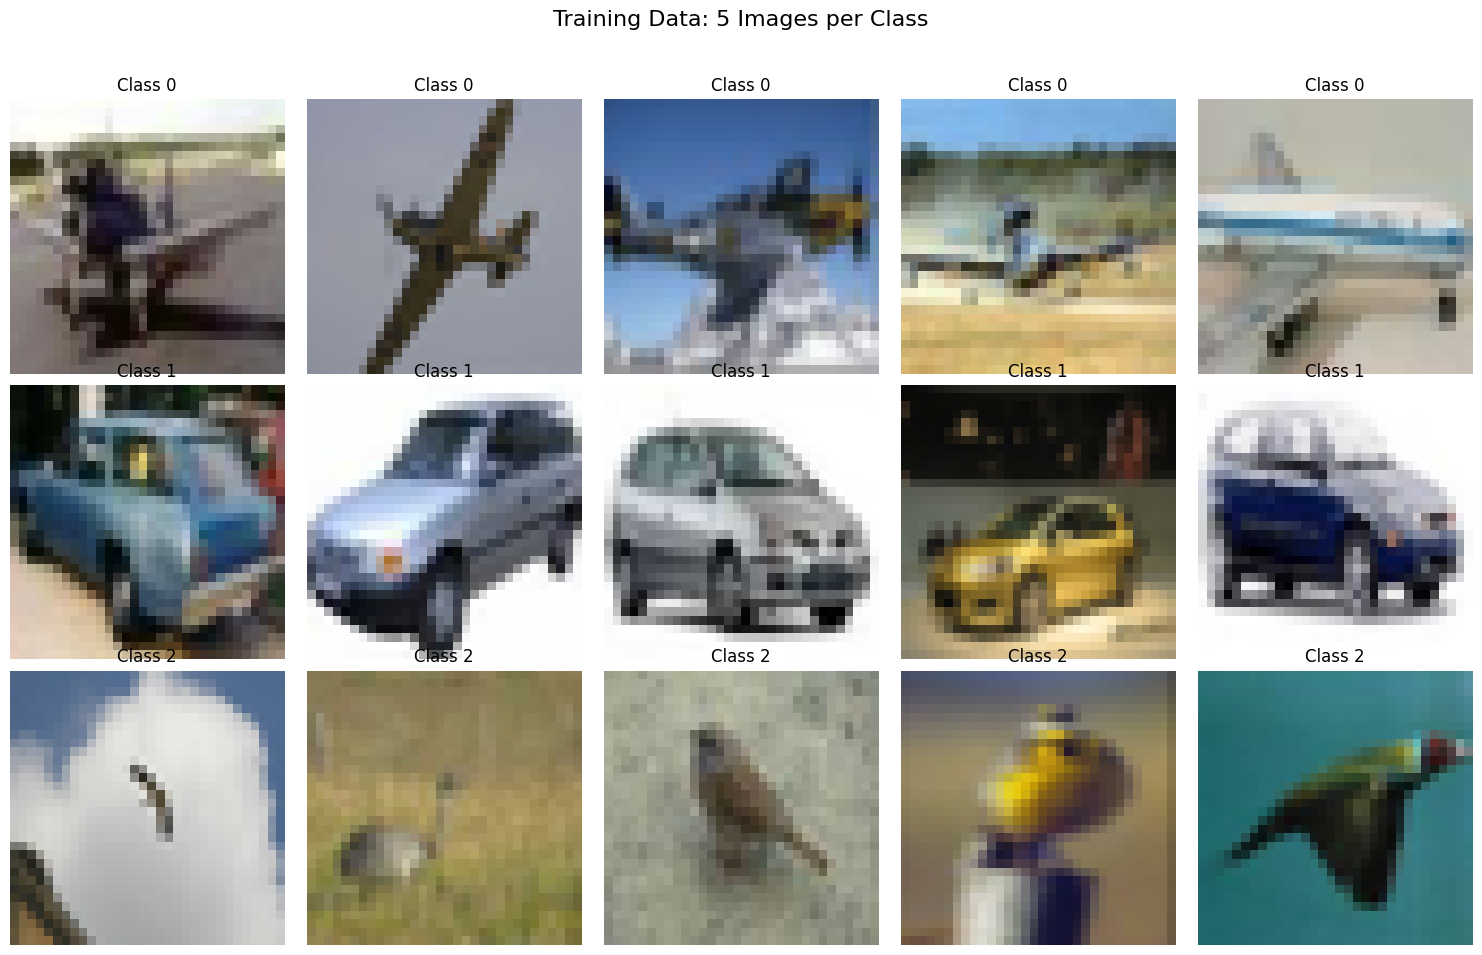

Visualizing validation data:


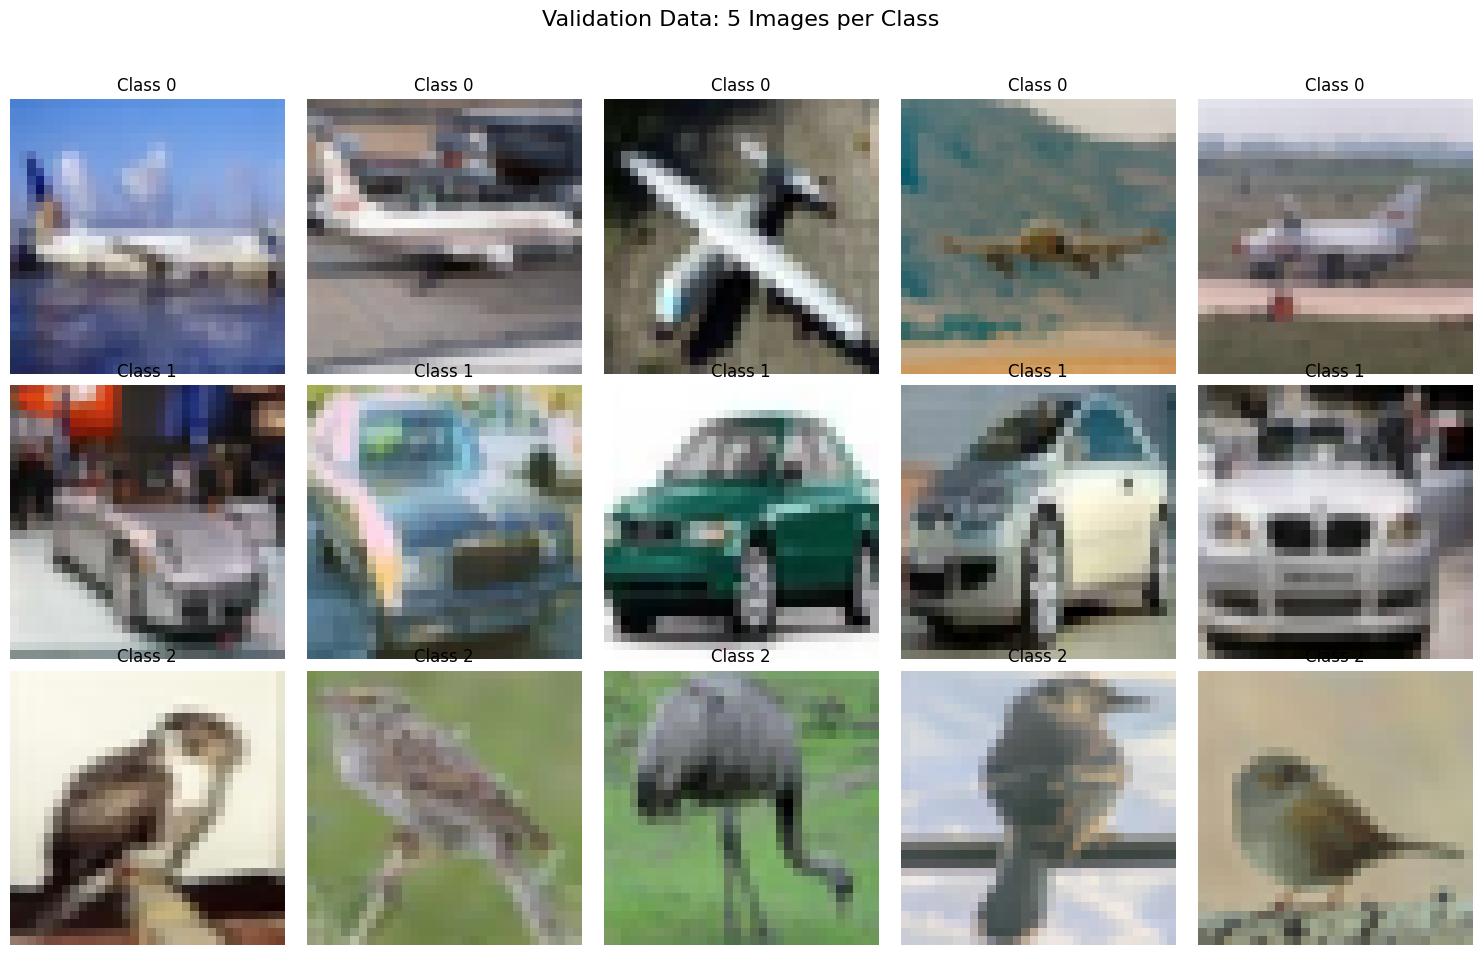

In [3]:
def visualize_images(dataloader, class_names, title, num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    class_counts = {cls: 0 for cls in range(len(class_names))}  

    for images, labels in dataloader:
        for image, label in zip(images, labels):  
            label = label.item()  
            if class_counts[label] < num_images:  
                row = label  
                col = class_counts[label]  
                axes[row, col].imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5) 
                axes[row, col].axis('off')
                axes[row, col].set_title(class_names[label])
                class_counts[label] += 1
            
            
            if all(count == num_images for count in class_counts.values()):
                break
        
        if all(count == num_images for count in class_counts.values()):
            break
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()

class_names = [f"Class {i}" for i in range(len(chosen_classes))]

print("Visualizing training data:")
visualize_images(train_loader, class_names, title="Training Data: 5 Images per Class")

print("Visualizing validation data:")
visualize_images(val_loader, class_names, title="Validation Data: 5 Images per Class")


In [4]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes=3): 
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)  
        self.fc1 = nn.Linear(32 * 4 * 4, 16)  
        self.fc2 = nn.Linear(16, num_classes)  
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool1(x)         
        x = F.relu(self.conv2(x))  
        x = self.pool2(x)          
        x = torch.flatten(x, 1)    
        x = F.relu(self.fc1(x))    
        x = self.fc2(x)            
        return x

num_classes = len(chosen_classes)  
model = CustomCNN(num_classes=num_classes)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [5]:
learning_rate = 0.001
num_epochs = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(num_classes=3).to(device)

criterion = torch.nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

def train_model(model, train_loader, val_loader, num_epochs):
    model = model.to(device)  
    saved_model_path = "cnn/final_cnn_model.pth"

    
    if os.path.exists(saved_model_path):
        print("Model already trained and loaded.")
        
        checkpoint = torch.load(saved_model_path)
        
        
        if 'model_state_dict' in checkpoint and 'history' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            history = checkpoint['history']
        else:
            raise KeyError("The checkpoint does not contain 'model_state_dict' or 'history'. Please check the saved file.")

       
        for epoch in range(len(history["train_loss"])):
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {history['train_loss'][epoch]:.4f}, "
                  f"Train Accuracy: {history['train_acc'][epoch]:.4f} - "
                  f"Val Loss: {history['val_loss'][epoch]:.4f}, "
                  f"Val Accuracy: {history['val_acc'][epoch]:.4f}")
        return history  

    os.makedirs("cnn", exist_ok=True)

    
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct, total = 0, 0
        
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        
        model.eval() 
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = correct / total

       
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

       
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history
        }, f"cnn/cnn_model_epoch_{epoch+1}.pth")
    
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history
    }, saved_model_path)
    print("Model trained and saved as 'cnn/final_cnn_model.pth'.")

    return history


history = train_model(model, train_loader, val_loader, num_epochs)


Model already trained and loaded.
Epoch [1/15] - Train Loss: 0.6863, Train Accuracy: 0.7098 - Val Loss: 0.5498, Val Accuracy: 0.7787
Epoch [2/15] - Train Loss: 0.4991, Train Accuracy: 0.8010 - Val Loss: 0.4993, Val Accuracy: 0.7970
Epoch [3/15] - Train Loss: 0.4414, Train Accuracy: 0.8253 - Val Loss: 0.4545, Val Accuracy: 0.8190
Epoch [4/15] - Train Loss: 0.4196, Train Accuracy: 0.8354 - Val Loss: 0.4581, Val Accuracy: 0.8243
Epoch [5/15] - Train Loss: 0.3910, Train Accuracy: 0.8472 - Val Loss: 0.4071, Val Accuracy: 0.8423
Epoch [6/15] - Train Loss: 0.3632, Train Accuracy: 0.8602 - Val Loss: 0.3846, Val Accuracy: 0.8500
Epoch [7/15] - Train Loss: 0.3537, Train Accuracy: 0.8609 - Val Loss: 0.3723, Val Accuracy: 0.8527
Epoch [8/15] - Train Loss: 0.3283, Train Accuracy: 0.8704 - Val Loss: 0.3649, Val Accuracy: 0.8560
Epoch [9/15] - Train Loss: 0.3256, Train Accuracy: 0.8725 - Val Loss: 0.3651, Val Accuracy: 0.8557
Epoch [10/15] - Train Loss: 0.3019, Train Accuracy: 0.8830 - Val Loss: 0.34

C:\Users\A13na\AppData\Local\Temp\ipykernel_70720\3595187596.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path)


C:\Users\A13na\AppData\Local\Temp\ipykernel_70720\3177280727.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


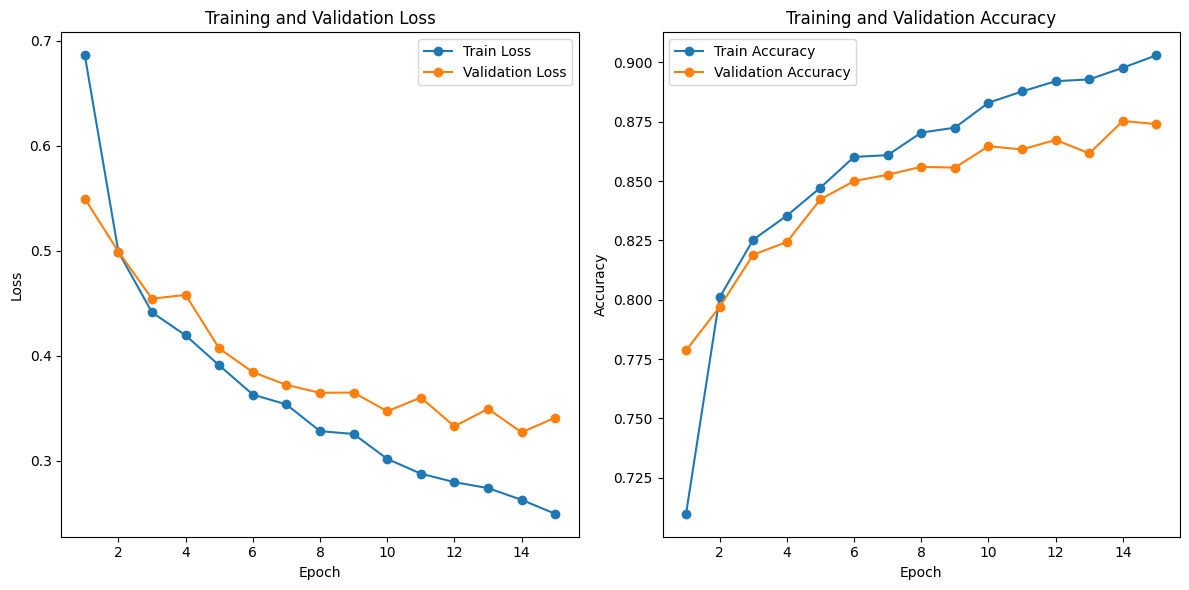

Test Accuracy: 0.8860
Test F1-Score: 0.8855


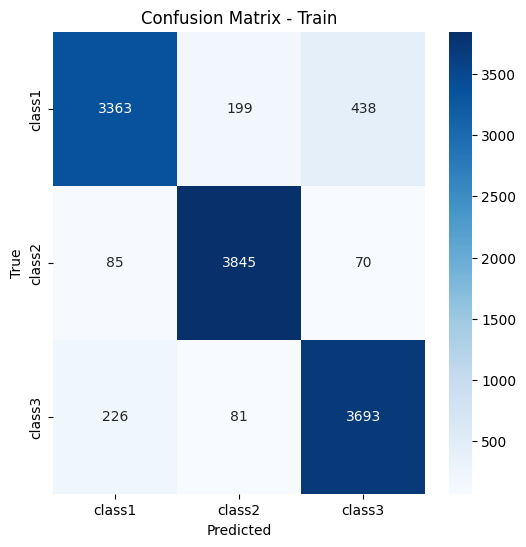

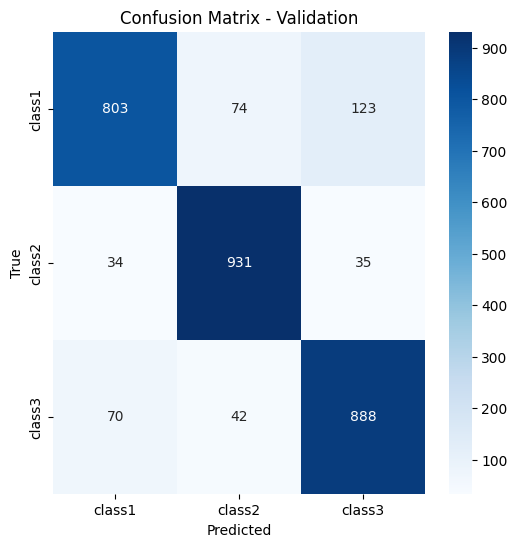

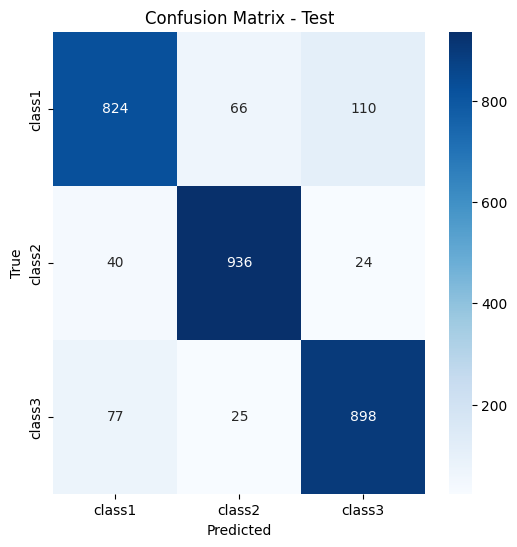

In [6]:
def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')  
    return accuracy, f1, y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


checkpoint_path = "cnn/final_cnn_model.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])  
model.to(device)


history = checkpoint['history']


plot_training_results(history)


test_accuracy, test_f1, test_y_true, test_y_pred = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

train_accuracy, train_f1, train_y_true, train_y_pred = evaluate_model(model, train_loader, device)
plot_confusion_matrix(train_y_true, train_y_pred, class_names=['class1', 'class2', 'class3'], title="Confusion Matrix - Train")

val_accuracy, val_f1, val_y_true, val_y_pred = evaluate_model(model, val_loader, device)
plot_confusion_matrix(val_y_true, val_y_pred, class_names=['class1', 'class2', 'class3'], title="Confusion Matrix - Validation")

plot_confusion_matrix(test_y_true, test_y_pred, class_names=['class1', 'class2', 'class3'], title="Confusion Matrix - Test")


In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)            
        x = self.relu(x)           
        x = self.fc2(x)            
        return x

input_size = 32 * 32 * 3  
hidden_size = 64
num_classes = 3           
learning_rate = 0.001
num_epochs = 15

criterion = nn.CrossEntropyLoss()

def train_mlp_model(model, train_loader, val_loader, num_epochs, device):
    model = model.to(device)  
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval() 
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        model_path = f"mlp/mlp_model_epoch_{epoch+1}.pth" 
        os.makedirs("mlp", exist_ok=True) 
        torch.save(model.state_dict(), model_path)
    
    final_model_path = "mlp/final_mlp.pth"
    torch.save(model.state_dict(), final_model_path)
    print("Final model saved as final_mlp.pth")

    return history

model_path = "mlp/mlp_model_epoch_15.pth"
if os.path.exists(model_path):
    model = MLP(input_size, hidden_size, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print("Model already trained and loaded.")
else:
    model = MLP(input_size, hidden_size, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    history = train_mlp_model(model, train_loader, val_loader, num_epochs, device)
    
    final_model_path = "mlp/final_mlp.pth"
    torch.save(model.state_dict(), final_model_path)
    print("Model trained and saved.")

print("Training and Validation Metrics:")
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {history['train_loss'][epoch]:.4f}, Train Accuracy: {history['train_acc'][epoch]:.4f} - "
          f"Val Loss: {history['val_loss'][epoch]:.4f}, Val Accuracy: {history['val_acc'][epoch]:.4f}")


Model already trained and loaded.
Training and Validation Metrics:
Epoch [1/15] - Train Loss: 0.6863, Train Accuracy: 0.7098 - Val Loss: 0.5498, Val Accuracy: 0.7787
Epoch [2/15] - Train Loss: 0.4991, Train Accuracy: 0.8010 - Val Loss: 0.4993, Val Accuracy: 0.7970
Epoch [3/15] - Train Loss: 0.4414, Train Accuracy: 0.8253 - Val Loss: 0.4545, Val Accuracy: 0.8190
Epoch [4/15] - Train Loss: 0.4196, Train Accuracy: 0.8354 - Val Loss: 0.4581, Val Accuracy: 0.8243
Epoch [5/15] - Train Loss: 0.3910, Train Accuracy: 0.8472 - Val Loss: 0.4071, Val Accuracy: 0.8423
Epoch [6/15] - Train Loss: 0.3632, Train Accuracy: 0.8602 - Val Loss: 0.3846, Val Accuracy: 0.8500
Epoch [7/15] - Train Loss: 0.3537, Train Accuracy: 0.8609 - Val Loss: 0.3723, Val Accuracy: 0.8527
Epoch [8/15] - Train Loss: 0.3283, Train Accuracy: 0.8704 - Val Loss: 0.3649, Val Accuracy: 0.8560
Epoch [9/15] - Train Loss: 0.3256, Train Accuracy: 0.8725 - Val Loss: 0.3651, Val Accuracy: 0.8557
Epoch [10/15] - Train Loss: 0.3019, Train 

C:\Users\A13na\AppData\Local\Temp\ipykernel_70720\3413280890.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


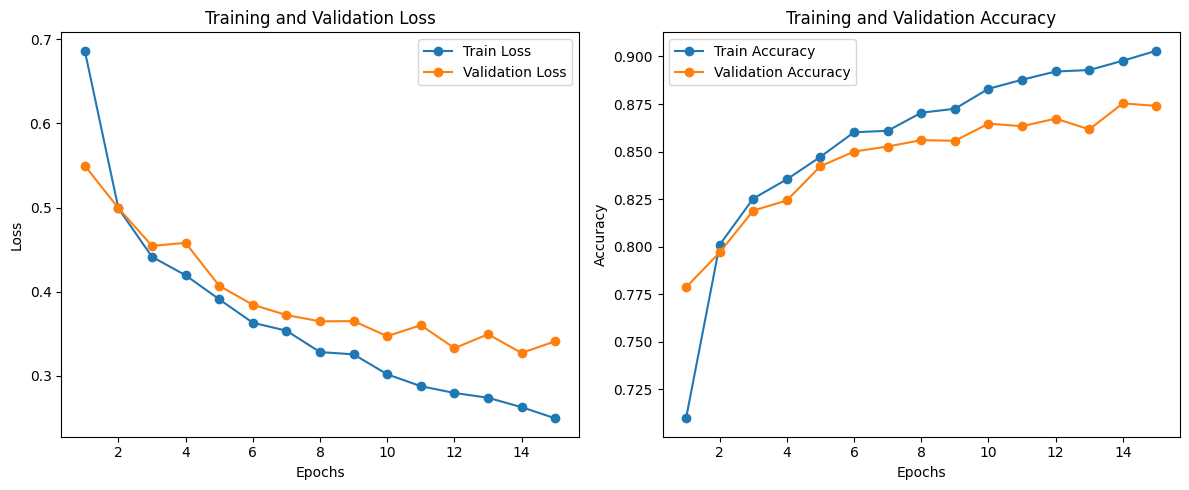

Test Accuracy: 0.7967
Test F1-Score: 0.7964


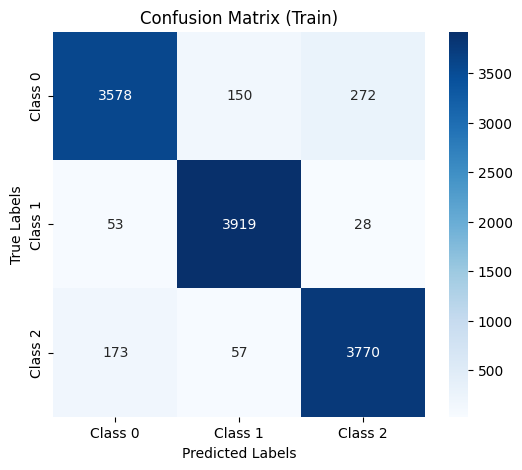

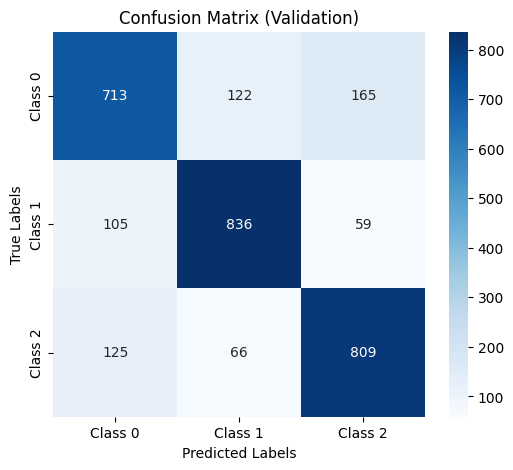

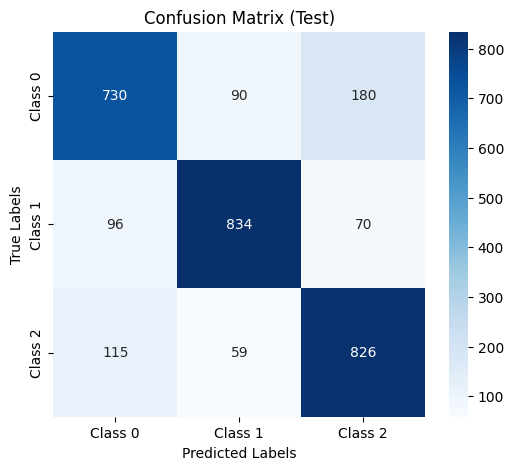

In [8]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

if 'history' in locals():
    plot_training_history(history)

def evaluate_model_on_test(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, f1, cm

test_accuracy, test_f1, test_cm = evaluate_model_on_test(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

def plot_confusion_matrix(cm, dataset_type):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
    plt.title(f"Confusion Matrix ({dataset_type})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

train_accuracy, train_f1, train_cm = evaluate_model_on_test(model, train_loader, device)
plot_confusion_matrix(train_cm, "Train")

val_accuracy, val_f1, val_cm = evaluate_model_on_test(model, val_loader, device)
plot_confusion_matrix(val_cm, "Validation")

plot_confusion_matrix(test_cm, "Test")


C:\Users\A13na\AppData\Local\Temp\ipykernel_70720\667174314.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("mlp/final_mlp.pth"))
C:

MLP Model - Test Accuracy: 0.7967, F1-score: 0.7964
CNN Model - Test Accuracy: 0.8860, F1-score: 0.8855


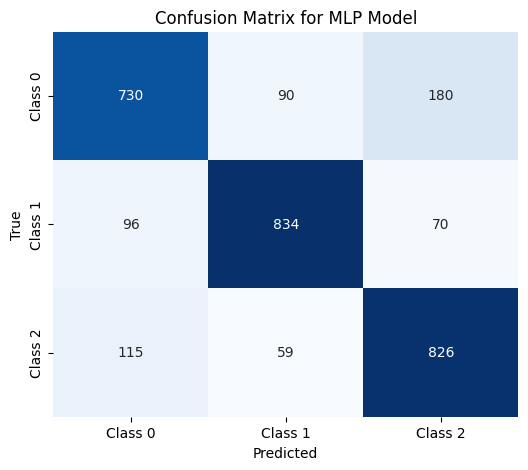

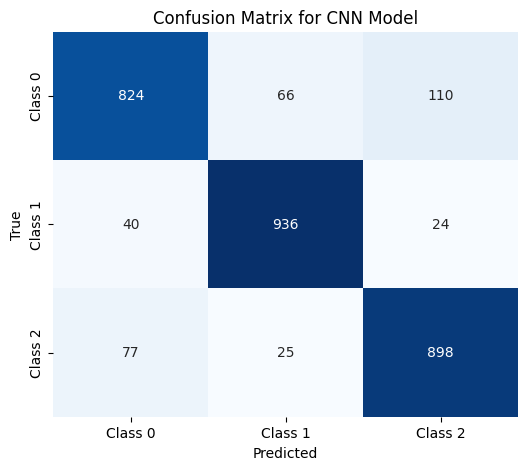


Comparison of Models:
MLP Model - Test Accuracy: 0.7967, F1-score: 0.7964
CNN Model - Test Accuracy: 0.8860, F1-score: 0.8855


In [9]:
mlp_model = MLP(input_size=32*32*3, hidden_size=64, num_classes=3).to(device)
mlp_model.load_state_dict(torch.load("mlp/final_mlp.pth"))
mlp_model.eval()

cnn_model = CustomCNN(num_classes=3).to(device)
cnn_checkpoint = torch.load("cnn/final_cnn_model.pth") 
cnn_model.load_state_dict(cnn_checkpoint['model_state_dict']) 
cnn_model.eval()

def compute_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, f1, cm

mlp_accuracy, mlp_f1, mlp_cm = compute_metrics(mlp_model, test_loader, device)
print(f"MLP Model - Test Accuracy: {mlp_accuracy:.4f}, F1-score: {mlp_f1:.4f}")

cnn_accuracy, cnn_f1, cnn_cm = compute_metrics(cnn_model, test_loader, device)
print(f"CNN Model - Test Accuracy: {cnn_accuracy:.4f}, F1-score: {cnn_f1:.4f}")

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(mlp_cm, "MLP Model")

plot_confusion_matrix(cnn_cm, "CNN Model")

print("\nComparison of Models:")
print(f"MLP Model - Test Accuracy: {mlp_accuracy:.4f}, F1-score: {mlp_f1:.4f}")
print(f"CNN Model - Test Accuracy: {cnn_accuracy:.4f}, F1-score: {cnn_f1:.4f}")
